In [546]:
import pickle
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cross_validation import train_test_split
pd.options.mode.chained_assignment = None
sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

with open("TEST_movie_data.pkl", 'r') as picklefile:
     all_movies = pickle.load(picklefile)
        
with open("director_movie_data.pkl", 'r') as picklefile:
     all_dir = pickle.load(picklefile)

In [547]:
dir_df = pd.DataFrame(all_dir)
dir_df['lifetime_films'] = dir_df['lifetime_films'].astype('int')
dir_df

,director,lifetime_films,lifetime_gross
0,Steven Spielberg,27,4155901520
1,Michael Bay,11,2143487601
2,Peter Jackson,12,2134703921
3,Robert Zemeckis,16,2039446164
4,James Cameron,9,1974307733
5,Ron Howard,21,1833703862
6,Christopher Nolan,9,1816484940
7,Tim Burton,17,1752990124
8,George Lucas,6,1743927001
9,Clint Eastwood,33,1690952072


In [645]:
df = pd.DataFrame(all_movies)
df['production_budget'] = df['production_budget']*1000000
df['budget'] = 0
df['budget'][df['imdb_budget'] != 0]  = df['imdb_budget']
df['budget'][df['imdb_budget'] == 0]  = df['production_budget']
df['month'] = df['release_date'].map(lambda x: x.month)
df['worldwide_gross'] = df['worldwide_gross'].where(df['worldwide_gross']!=0, np.nan) 
df['foreign_gross'] = df['foreign_gross'].where(df['foreign_gross']!=0, np.nan) 
df['budget'] = df['budget'].where(df['budget']!=0, np.nan) 
df = df.sort(['domestic_gross'], ascending = False)
df = df[df.budget <= 270000000]
df = df.merge(dir_df,on='director')
df['budget_var'] = df['production_budget']-df['imdb_budget']
df['lifetime_films'] = df['lifetime_films'].where(df['lifetime_films']!=0, np.nan) 
df['lifetime_gross'] = df['lifetime_gross'].where(df['lifetime_gross']!=0, np.nan) 
df['lifetime_films'] = df['lifetime_films'].astype('int')
df = df.sort(['budget_var'], ascending = False)
#Fixing values - don't do this in real life!!!  Just fix the scraper.
df.set_value(178, 'budget', 65000000)
df.set_value(179, 'budget', 125000000)
df.set_value(141, 'budget', 150000000)
df.set_value(371, 'budget', 30000000)
df.set_value(345, 'budget', 35000000)
df.set_value(150, 'budget', 100000000)
df.set_value(330, 'budget', 45000000)
df.set_value(133, 'budget', 100000000)
df.set_value(269, 'budget', 28000000)
df.set_value(127, 'budget', 40000000)
df.set_value(258, 'budget', 10000000)
df.set_value(308, 'budget', 3500000)
df.set_value(235, 'budget', 4000000)
df.set_value(234, 'budget', 2000000)
df.set_value(329, 'budget', 16000000)

df['roi'] = df['worldwide_gross']/df['budget']
df['roi'] = df['roi'].where(df['roi']!=0, np.nan)
df['dir_average']  = df['lifetime_gross']/df['lifetime_films']
df = df.sort(['roi'], ascending = False)
df['films_bins'] = 0
df['films_bins'] = df['films_bins'].where(df['lifetime_films']<10, 10)
df['films_bins'] = df['films_bins'].where(df['lifetime_films']>=10, 0)
df = df[df.roi < 40]
df
#cleandf = df[(df['budget_var']!=0) & (df['production_budget']!=0) & (df['imdb_budget']!=0)]
#cleandf

,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,title,worldwide_gross,budget,month,lifetime_films,lifetime_gross,budget_var,roi,dir_average,films_bins
135,John R. Leonetti,Warner Bros. (New Line),84273813,171000000,Horror,6500000,6500000,R,2014-10-03,95,Annabelle,255273813,6500000,10,2,120201219,0,39.272894,6.010061e+07,0
66,James Wan,FilmDistrict,83586447,78332871,Horror,0,5000000,PG-13,2013-09-13,105,Insidious Chapter 2,161919318,5000000,9,7,708372351,5000000,32.383864,1.011961e+08,0
234,Michael Tiddes,Open Road Films,40041683,20100000,Comedy,2000000,2500000,R,2013-01-11,80,A Haunted House,60141683,2000000,1,2,57371169,500000,30.070842,2.868558e+07,0
152,James DeMonaco,Universal,64473115,24855512,Thriller,3000000,3000000,R,2013-06-07,85,The Purge,89328627,3000000,6,2,136435915,0,29.776209,6.821796e+07,0
196,Henry Joost,Paramount,53900335,88917657,Horror,5000000,5000000,R,2012-10-19,95,Paranormal Activity 4,142817992,5000000,10,3,161166485,0,28.563598,5.372216e+07,0
213,Scott Derrickson,Lionsgate/Summit,48086903,29625536,Horror,3000000,3000000,R,2012-10-12,110,Sinister,77712439,3000000,10,4,233103457,0,25.904146,5.827586e+07,0
87,Josh Boone,Fox,124872350,182366663,Drama,12000000,12000000,PG-13,2014-06-06,125,The Fault in our Stars,307239013,12000000,6,2,124953421,0,25.603251,6.247671e+07,0
98,Steven Soderbergh,Warner Bros.,113721571,53500000,Comedy / Drama,7000000,7000000,R,2012-06-29,110,Magic Mike,167221571,7000000,6,26,1039340590,0,23.888796,3.997464e+07,10
205,Stiles White,Universal,50856010,51673769,Horror,5000000,5000000,PG-13,2014-10-24,89,Ouija,102529779,5000000,10,1,50856010,0,20.505956,5.085601e+07,0
65,James Wan,Warner Bros.,137400141,180600000,Horror,20000000,20000000,R,2013-07-19,112,The Conjuring,318000141,20000000,7,7,708372351,0,15.900007,1.011961e+08,0


In [549]:
newdf = df[(df['lifetime_films']>1)]
newdf = newdf.sort(['roi'], ascending = True)

In [581]:
y, X = dmatrices('worldwide_gross ~ budget + dir_average + month  ', data=df, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     308.9
Date:                Fri, 17 Jul 2015   Prob (F-statistic):          2.07e-101
Time:                        00:58:10   Log-Likelihood:                -7695.5
No. Observations:                 383   AIC:                         1.540e+04
Df Residuals:                     379   BIC:                         1.541e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -7.652e+07   1.67e+07     -4.591      0.000     -1.09e+08 -4.37e+07
budget          2.3255      0.151     15.364      0.000         2.028     2.623
dir_average     1.6001      0.156     10.280      0.000         1.294     1.906
month         4.81e+06   1.93e+06      2.496      0.013      1.02e+06   8.6e+06
==============================================================================
Omnibus:                       78.000   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              554.886
Skew:                           0.631   Prob(JB):                    3.22e-121
Kurtosis:                       8.760   Cond. No.                     2.77e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

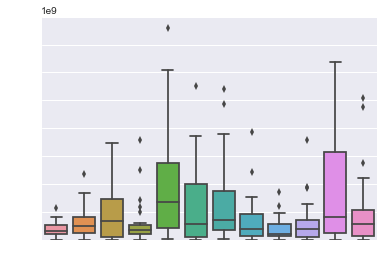

In [589]:
sns.set_palette("husl")
sns.boxplot(x = "month", y = "worldwide_gross", data = df.sort("month"))
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

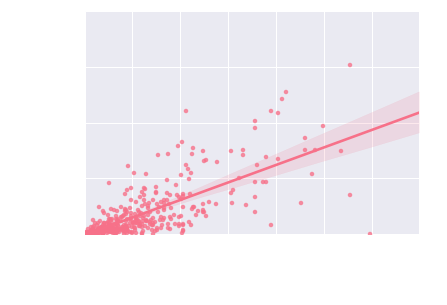

In [620]:
sns.regplot(x="dir_average", y="worldwide_gross", data=df)
ax = plt.gca()
plt.xlabel("Director Average")
plt.ylabel("Worldwide Gross")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

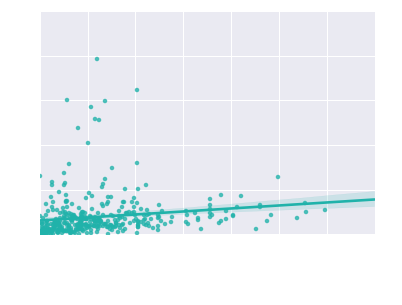

In [646]:
sns.regplot(x="dir_average", y="roi", data=df, color = '#20B2AA')
ax = plt.gca()
plt.xlabel("Director Average")
plt.ylabel("ROI")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

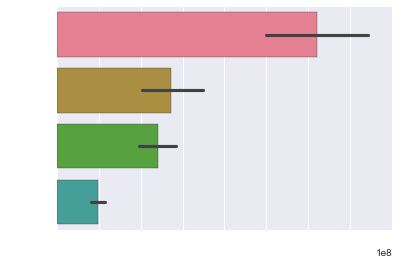

In [588]:
rating_df = df[(df["rating"] == "G") | (df['rating'] == "PG") | (df['rating'] == "PG-13") | (df['rating'] == "R")]
sns.barplot(x="worldwide_gross", y="rating", data=rating_df.sort('rating'))
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

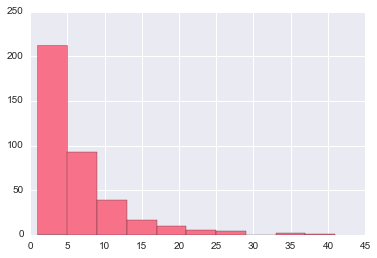

In [553]:
df.lifetime_films.hist()

newdf.worldwide_gross.hist()

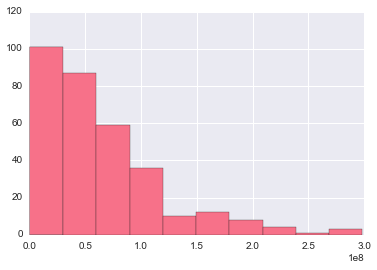

In [554]:
newdf.dir_average.hist()

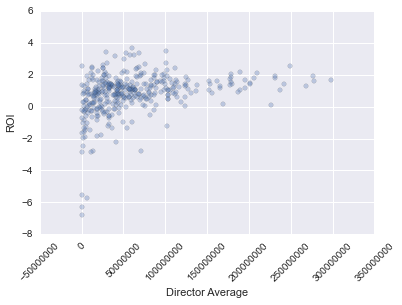

In [555]:
plt.scatter(df.dir_average, np.log(df.roi), alpha=0.3)
plt.xlabel("Director Average")
plt.ylabel("ROI")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()

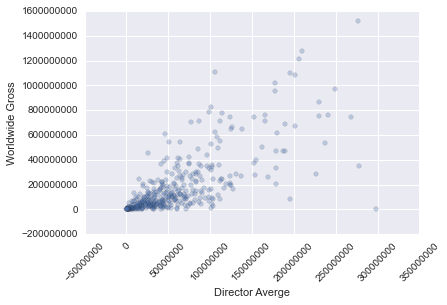

In [556]:
plt.scatter(X.dir_average, y, alpha=0.3)
plt.xlabel("Director Averge")
plt.ylabel("Worldwide Gross")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()

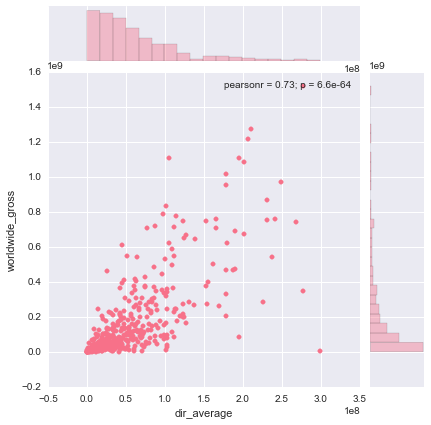

In [557]:
sns.jointplot(x='dir_average', y='worldwide_gross', data=df)

In [558]:
#simple_df = df[['director','distributor', 'genre', 'domestic_gross', 'budget', 'release_date', 'runtime','title','month', 
#               'lifetime_gross', 'lifetime_films', 'roi']]
#g = sns.PairGrid(simple_df)

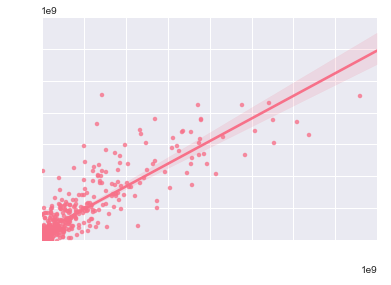

In [607]:
ypred = results.predict()
sns.regplot(x=y, y=ypred, data = df)
plt.xlabel("Actual Gross")
plt.ylabel("Predicted Gross")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

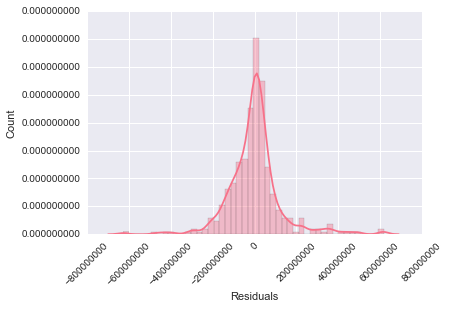

In [560]:
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.ticklabel_format(useOffset=False, style='plain')
yres = results.resid
sns.distplot(yres)
plt.xticks(rotation=45)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

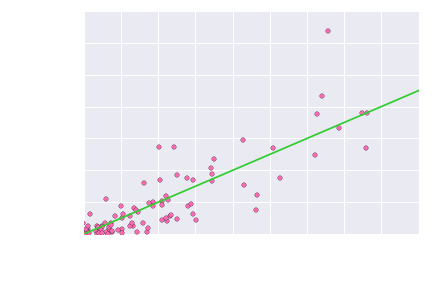

In [603]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

ytestpred = model.predict(x_test)
plt.scatter(x=ytestpred, y=y_test, c = "#FF69B4")
plt.xlabel("Model predicted y values")
plt.ylabel("Test y values")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.ticklabel_format(useOffset=False, style='plain')
#ax.set_xticks(np.arange(0, 30, 5))
#ax.set_yticks(np.arange(0, 30, 5))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xticks(rotation=45)
plt.plot([0,1000000000],[0,1000000000],'#32CD32')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

In [562]:
model = sm.OLS(y_test, x_test)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     83.53
Date:                Fri, 17 Jul 2015   Prob (F-statistic):           3.60e-26
Time:                        00:55:15   Log-Likelihood:                -1922.3
No. Observations:                  96   AIC:                             3853.
Df Residuals:                      92   BIC:                             3863.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -8.688e+07   3.51e+07     -2.472      0.015     -1.57e+08 -1.71e+07
budget          2.1598      0.275      7.841      0.000         1.613     2.707
dir_average     1.7738      0.246      7.199      0.000         1.284     2.263
month         5.24e+06   3.73e+06      1.406      0.163     -2.16e+06  1.26e+07
==============================================================================
Omnibus:                       42.856   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.991
Skew:                           1.359   Prob(JB):                     3.03e-40
Kurtosis:                       9.173   Cond. No.                     3.16e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [563]:
model = sm.OLS(y_train, x_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     224.3
Date:                Fri, 17 Jul 2015   Prob (F-statistic):           1.78e-74
Time:                        00:55:15   Log-Likelihood:                -5772.1
No. Observations:                 287   AIC:                         1.155e+04
Df Residuals:                     283   BIC:                         1.157e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -7.335e+07   1.91e+07     -3.839      0.000     -1.11e+08 -3.57e+07
budget          2.4019      0.184     13.041      0.000         2.039     2.764
dir_average     1.5089      0.199      7.570      0.000         1.117     1.901
month        4.755e+06   2.28e+06      2.089      0.038      2.75e+05  9.24e+06
==============================================================================
Omnibus:                       51.810   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.743
Skew:                           0.434   Prob(JB):                     3.85e-85
Kurtosis:                       8.635   Cond. No.                     2.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is the probability a movie doubles it's initial investment given that it's director has made 10 or more movies?

In [564]:
recoup = len(df[df.roi > 2.0])
total = len(df)
per_recoup = float(recoup)/float(total)
print recoup, "/", total
print "P(recoup):", per_recoup

251 / 383
P(recoup): 0.655352480418


In [565]:
high_vol_dir = len(dir_df[(dir_df['lifetime_films']>5.0)])
total_dir = len(dir_df)
per_dir = float(high_vol_dir)/float(total_dir)
print high_vol_dir, "/", total_dir
print "P(director more than 10 films):", per_dir

237 / 827
P(director more than 10 films): 0.286577992745


In [566]:
bayes_df = df[(df['roi']>2.0)]
high_vol_dir_given_recoup = len(bayes_df[bayes_df.lifetime_films > 5])
per_given = float(high_vol_dir_given_recoup/float(len(bayes_df)))
print high_vol_dir_given_recoup, "/", len(bayes_df)
print "P(dir more than 10 films given film recoup):", per_given

83 / 251
P(dir more than 10 films given film recoup): 0.330677290837


In [567]:
bayes_calc = (per_given*per_recoup)/per_dir
print bayes_calc

0.756199667295


In [568]:
final_df = df[(df.lifetime_films > 10) & (df.roi > 2.0)]
final_df

,director,distributor,domestic_gross,foreign_gross,genre,imdb_budget,production_budget,rating,release_date,runtime,title,worldwide_gross,budget,month,lifetime_films,lifetime_gross,budget_var,roi,dir_average,films_bins
26,Michael Bay,Paramount,245439076,858600000,Sci-Fi Action,210000000,210000000,PG-13,2014-06-27,165,Transformers: Age of Extinction,1104039076,210000000,6,11,2143487601,0,5.257329,1.948625e+08,10
27,Michael Bay,Paramount,49875291,36300000,Action,0,26000000,R,2013-04-26,129,Pain and Gain,86175291,26000000,4,11,2143487601,26000000,3.314434,1.948625e+08,10
14,Peter Jackson,Warner Bros.,255119788,700000000,Fantasy,250000000,0,PG-13,2014-12-17,144,The Hobbit: The Battle of the Five Armies,955119788,250000000,12,12,2134703921,-250000000,3.820479,1.778920e+08,10
13,Peter Jackson,Warner Bros.,303003568,714000000,Fantasy,180000000,0,PG-13,2012-12-14,166,The Hobbit: An Unexpected Journey,1017003568,180000000,12,12,2134703921,-180000000,5.650020,1.778920e+08,10
49,Steven Spielberg,Buena Vista,182207973,93085477,Historical Drama,65000000,65000000,PG-13,2012-11-09,145,Lincoln,275293450,65000000,11,27,4155901520,0,4.235284,1.539223e+08,10
119,Robert Zemeckis,Paramount,93772375,68000000,Drama,31000000,31000000,R,2012-11-02,139,Flight,161772375,31000000,11,16,2039446164,0,5.218464,1.274654e+08,10
31,Sam Raimi,Buena Vista,234911825,258400000,Adventure,215000000,215000000,PG,2013-03-08,127,Oz The Great and Powerful,493311825,215000000,3,14,1526694668,0,2.294474,1.090496e+08,10
142,Tim Burton,Buena Vista,35291068,46200000,Animation,39000000,39000000,PG,2012-10-05,87,Frankenweenie,81491068,39000000,10,17,1752990124,0,2.089515,1.031171e+08,10
143,Tim Burton,Weinstein Company,14482031,14771135,Drama,10000000,0,PG-13,2014-12-25,106,Big Eyes,29253166,10000000,12,17,1752990124,-10000000,2.925317,1.031171e+08,10
95,Shawn Levy,Fox,113746621,246625469,Family Adventure,127000000,127000000,PG,2014-12-19,97,Night at the Museum: Secret of the Tomb,360372090,127000000,12,11,1130331333,0,2.837576,1.027574e+08,10


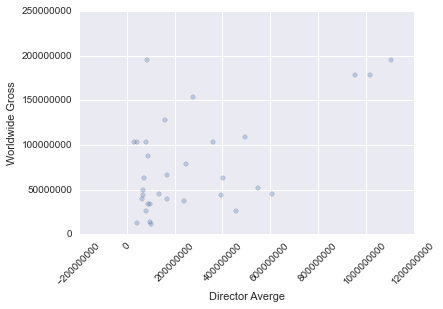

In [569]:
plt.scatter(final_df.worldwide_gross, final_df.dir_average, alpha=0.3)
plt.xlabel("Director Averge")
plt.ylabel("Worldwide Gross")
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.xticks(rotation=45)
plt.show()